# **Inverse Probability of Treatment Weighting [IPTW]**

**Notes:**

- Based on the idea that instead of **matching**, we could use all of the data, but **down-weight** some and **up-weight** others.
- Weighting by the **inverse probability of treatment received**.
- [Horvitz-Thompson Estimator](https://en.wikipedia.org/wiki/Horvitz%E2%80%93Thompson_estimator) is commonly used.
- Weighted means and variances are used for covariate balance computation.
- Large weights can be common, needs to do trimming, truncating or bootstrapping to manage outliers.
    

- [**Marginal Structural Models**](https://journals.lww.com/epidem/fulltext/2000/09000/marginal_structural_models_and_causal_inference_in.11.aspx#:~:text=Marginal%20structural%20models%20(MSMs%29%20are,simultaneously%20confounders%20and%20intermediate%20variables.)
     - Can be used more generally to estimate Causal Effect Parameters from models
     - **Marginal**: model that is not conditional on the confounders (population average)
     - **Structural**: model for potential outcomes, not observed outcomes
 
 
- [**Doubly Robust Estimators**](https://matheusfacure.github.io/python-causality-handbook/12-Doubly-Robust-Estimation.html)
    - Typically used as an ensemble of Outcome Regression and Propensity Score Model.
    - Unbiased even if either one of the PSM or Outcome Regression Model is incorrect.
    - Also called Augmented IPTW (AIPTW) estimators, and is more efficient than regular IPTW estimators.


- [IPTW vs PSM](https://stats.stackexchange.com/questions/424223/advantages-and-disadvantages-of-iptw-vs-propensity-score-matching)

In [1]:
#install needed libraries
install.packages("tableone")
install.packages("ipw")
install.packages("sandwich")
install.packages("survey")
install.packages("Matching")
install.packages("MatchIt")

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



## **Load Libraries and Data**

In [2]:
library(tableone)
library(Matching)
library(MatchIt)
library(ipw)
library(survey)

Loading required package: MASS

## 
##  Matching (Version 4.9-11, Build Date: 2021-10-18)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##


Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: ‘survey’


The following object is masked from ‘package:graphics’:

    dotchart




In [3]:
data("lalonde")
lalonde$race_black = ifelse(lalonde$race=='black', 1, 0)
lalonde$race_hisp = ifelse(lalonde$race=='hispan', 1, 0)
head(lalonde)

,treat,age,educ,race,married,nodegree,re74,re75,re78,race_black,race_hisp
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,black,1,1,0,0,9930.0460,1,0
NSW2,1,22,9,hispan,0,1,0,0,3595.8940,0,1
NSW3,1,30,12,black,0,0,0,0,24909.4500,1,0
NSW4,1,27,11,black,0,1,0,0,7506.1460,1,0
NSW5,1,33,8,black,0,1,0,0,289.7899,1,0
NSW6,1,22,9,black,0,1,0,0,4056.4940,1,0


In [4]:
#using table one
#covariates we will use (shorter list than you would use in practice)
covariates <-c ("age","educ", "race_black", "race_hisp", "married","nodegree","re74","re75")
covar_table_1 <- CreateTableOne(vars=covariates,strata="treat", data=lalonde, test=FALSE)
# include standardized mean difference (SMD)
print(covar_table_1,smd=TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                          429               185                 
  age (mean (SD))          28.03 (10.79)     25.82 (7.16)     0.242
  educ (mean (SD))         10.24 (2.86)      10.35 (2.01)     0.045
  race_black (mean (SD))    0.20 (0.40)       0.84 (0.36)     1.668
  race_hisp (mean (SD))     0.14 (0.35)       0.06 (0.24)     0.277
  married (mean (SD))       0.51 (0.50)       0.19 (0.39)     0.719
  nodegree (mean (SD))      0.60 (0.49)       0.71 (0.46)     0.235
  re74 (mean (SD))       5619.24 (6788.75) 2095.57 (4886.62)  0.596
  re75 (mean (SD))       2466.48 (3292.00) 1532.06 (3219.25)  0.287


## **Propensity Scoring**

### **Using GLM**

In [6]:
model_ps <-glm("treat ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75",
    family=binomial(link ="logit"), data=lalonde)
summary(model_ps)


Call:
glm(formula = "treat ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75", 
    family = binomial(link = "logit"), data = lalonde)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7645  -0.4736  -0.2862   0.7508   2.7169  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.729e+00  1.017e+00  -4.649 3.33e-06 ***
age          1.578e-02  1.358e-02   1.162  0.24521    
educ         1.613e-01  6.513e-02   2.477  0.01325 *  
race_black   3.065e+00  2.865e-01  10.699  < 2e-16 ***
race_hisp    9.836e-01  4.257e-01   2.311  0.02084 *  
married     -8.321e-01  2.903e-01  -2.866  0.00415 ** 
nodegree     7.073e-01  3.377e-01   2.095  0.03620 *  
re74        -7.178e-05  2.875e-05  -2.497  0.01253 *  
re75         5.345e-05  4.635e-05   1.153  0.24884    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 751.49  on 613  deg

In [7]:
scores_ps <- predict(model_ps, type = "response")
summary(scores_ps)
#create weights
weights <- ifelse(lalonde$treat==1,1/(scores_ps),1/(1-scores_ps))
summary(weights)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00908 0.04854 0.12068 0.30130 0.63872 0.85315 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.009   1.052   1.170   1.905   1.623  40.077 

In [8]:
#apply weights to data
data_weighted <- svydesign(ids = ~ 1, data = lalonde, weights = ~ weights)

#weighted table 1
table_weighted <- svyCreateTableOne(vars = covariates, strata = "treat", 
                                 data = data_weighted, test = FALSE)
## Show table with SMD
print(table_weighted, smd = TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                       616.00            553.63                 
  age (mean (SD))          27.10 (10.80)     25.57 (6.53)     0.172
  educ (mean (SD))         10.29 (2.74)      10.61 (2.05)     0.132
  race_black (mean (SD))    0.40 (0.49)       0.45 (0.50)     0.101
  race_hisp (mean (SD))     0.12 (0.32)       0.12 (0.33)     0.014
  married (mean (SD))       0.41 (0.49)       0.31 (0.47)     0.197
  nodegree (mean (SD))      0.62 (0.48)       0.57 (0.50)     0.112
  re74 (mean (SD))       4552.74 (6337.09) 2932.18 (5709.42)  0.269
  re75 (mean (SD))       2172.04 (3160.14) 1658.07 (3072.89)  0.165


In [12]:
#to get a weighted mean for a single covariate directly:
mean(weights[lalonde$treat==1]*lalonde$educ[lalonde$treat==1])/(mean(weights[lalonde$treat==1]))

[1] 10.60635

### **IPTW**

#### **Estimate Inverse Probability of Treatment Weights**

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.009   1.052   1.170   1.905   1.623  40.077 

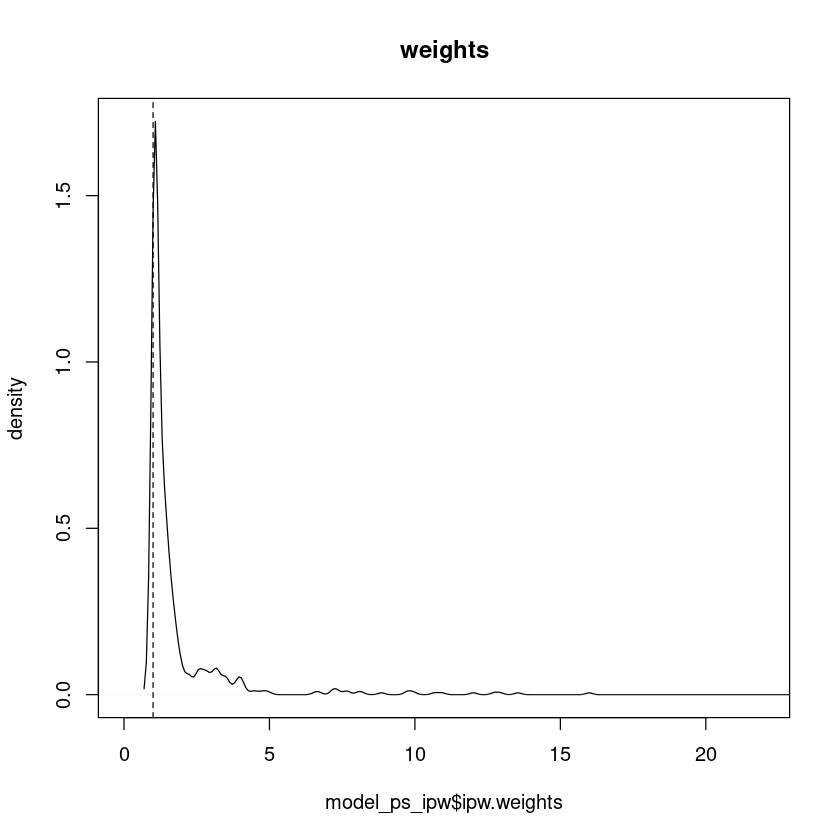

In [13]:
#first fit propensity score model to get weights
model_ps_ipw <- ipwpoint(exposure = treat, family = "binomial", link ="logit",
          denominator= ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75, data=lalonde)
#numeric summary of weights
summary(model_ps_ipw$ipw.weights)
#plot of weights
ipwplot(weights = model_ps_ipw$ipw.weights, logscale = FALSE,
         main = "weights", xlim = c(0, 22))

#### **Fit a Marginal Structural Model**

In [16]:
lalonde$wt<-model_ps_ipw$ipw.weights
#fit a marginal structural model (risk difference)
msm <- (svyglm(re78 ~ treat, design = svydesign(~ 1, weights = ~wt,
                  data = lalonde)))
coef(msm)
confint(msm, level = 0.95)

(Intercept)       treat 
  6422.8390    224.6763

,2.5 %,97.5 %
(Intercept),5705.529,7140.149
treat,-1562.856,2012.208


In [17]:
head(lalonde)

,treat,age,educ,race,married,nodegree,re74,re75,re78,race_black,race_hisp,wt
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,black,1,1,0,0,9930.0460,1,0,1.565509
NSW2,1,22,9,hispan,0,1,0,0,3595.8940,0,1,4.451681
NSW3,1,30,12,black,0,0,0,0,24909.4500,1,0,1.474396
NSW4,1,27,11,black,0,1,0,0,7506.1460,1,0,1.288122
NSW5,1,33,8,black,0,1,0,0,289.7899,1,0,1.425235
NSW6,1,22,9,black,0,1,0,0,4056.4940,1,0,1.430472


#### **Estimate Truncated Inverse Probability of Treatment Weights**

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.020   1.052   1.170   1.589   1.623   4.040 

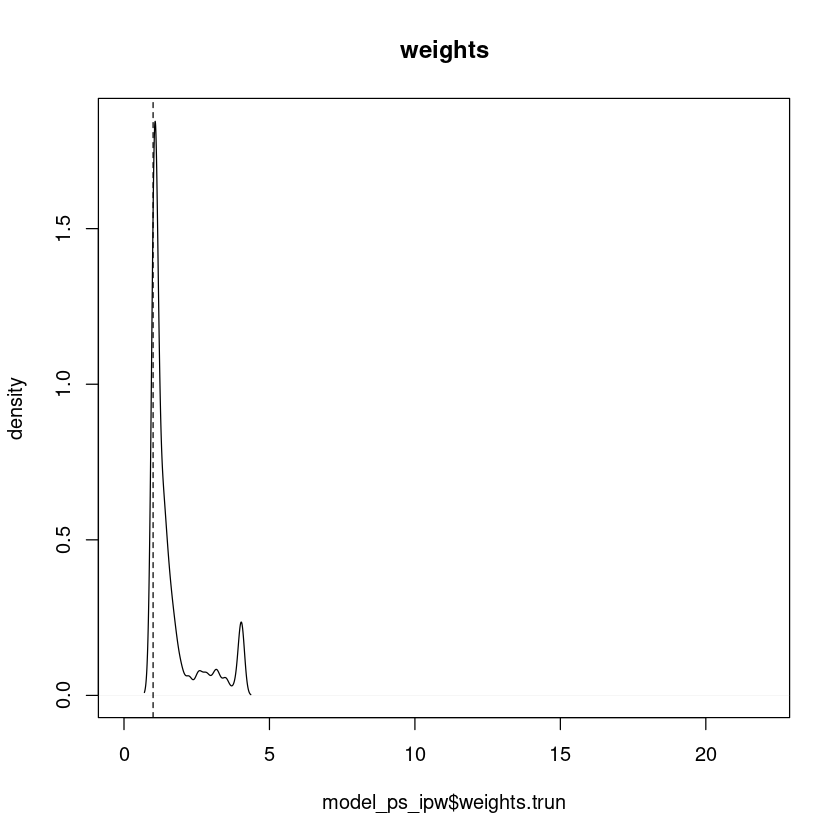

In [23]:
# Truncate
model_ps_ipw <-ipwpoint(exposure = treat, family = "binomial", link ="logit",
          denominator= ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75, data=lalonde, trunc=0.05)
#numeric summary of weights
summary(model_ps_ipw$weights.trun)
#plot of weights
ipwplot(weights = model_ps_ipw$weights.trun, logscale = FALSE,
         main = "weights", xlim = c(0, 22))

#### **Fit a Marginal Structural Model**

In [24]:
lalonde$wt<-model_ps_ipw$weights.trun
#fit a marginal structural model (risk difference)
msm <- (svyglm(re78 ~ treat, design = svydesign(~ 1, weights = ~wt,
                  data =lalonde)))
coef(msm)
confint(msm, level = 0.95)

(Intercept)       treat 
  6432.0160    336.9684

,2.5 %,97.5 %
(Intercept),5714.412,7149.620
treat,-1104.334,1778.271
